In [1]:
import numpy as np
import numpy.linalg as la
import scipy.sparse as sps
import scipy.sparse.linalg as spsla
import matplotlib.pyplot as plt
import sys, time, os
import cvxpy as cvx
sys.path.append('../..')
%load_ext autoreload
%autoreload 2

In [2]:
import problems, projection, optimize, util
from tomo1D import blur_1d
from tomo2D import blur_2d

# questions
---

> 1. how choose regularization parameters?
> 2. meaning of variation in $K_b$ diagonal?
> 3. get original signal to plot reconstructed signal vs original?
> 4. how to determine 'best' template for cases with poor conditioning (i.e., what to compare CVX templates to)? / are the direct & pinv templates reliable in these cases (I would think no)?

# setup
---

In [3]:
# load data
X = np.load('../../../data/HOTomoMats/Amat.npy')
M = np.load('../../../data/HOTomoMats/Mmat.npy')
sb = np.load('../../../data/HOTomoMats/sb.npy')
lams = np.load('../../../data/HOTomoMats/lambdas.npy')
Kb_diag = np.load('../../../data/HOTomoMats/DiagKb.npy')
Kb = np.diag(Kb_diag)

# jake testing lam closer to zero
lams = np.append(lams, [1e-6, 1e-8, 1e-10, 1e-12, 1e-14, 1e-16, 1e-28])
print('lams: %s' % lams)

# convert to sparse / vector
X = sps.csr_matrix(X)
M = M*1
M = sps.csr_matrix(M)
Kb = sps.csr_matrix(Kb)
sb = sb.reshape(len(sb),1)

# set sizes
k = M.shape[0]
n_1, n_2 = 35, 70
n = n_1 * n_2
m = Kb.shape[0]

# print sizes
print('k: %s' % k)      # roi
print('n_1: %s' % n_1)  # n rows
print('n_2: %s' % n_2)  # n cols
print('n: %s' % n)      # image space dim
print('m: %s' % m)      # data space dim
print(type(X), 'X size: (%s,%s)' % X.shape, 'nnz: %s' % X.count_nonzero())
print(type(M), 'M size: (%s,%s)' % M.shape, 'M', 'nnz: %s' % M.count_nonzero())
print(type(Kb), 'Kb size: (%s,%s)' % Kb.shape, 'Kb', 'nnz: %s' % Kb.count_nonzero())
print(type(sb), 'sb size: (%s,%s)' % sb.shape, 'sb', 'nnz: %s' % np.count_nonzero(sb))

lams: [  9.08303756e+02   9.08303756e+00   9.08303756e-02   9.08303756e-04   1.00000000e-06   1.00000000e-08   1.00000000e-10   1.00000000e-12   1.00000000e-14   1.00000000e-16   1.00000000e-28]
k: 30
n_1: 35
n_2: 70
n: 2450
m: 1050
(<class 'scipy.sparse.csr.csr_matrix'>, 'X size: (1050,2450)', 'nnz: 62307')
(<class 'scipy.sparse.csr.csr_matrix'>, 'M size: (30,2450)', 'M', 'nnz: 30')
(<class 'scipy.sparse.csr.csr_matrix'>, 'Kb size: (1050,1050)', 'Kb', 'nnz: 1050')
(<type 'numpy.ndarray'>, 'sb size: (1050,1)', 'sb', 'nnz: 312')


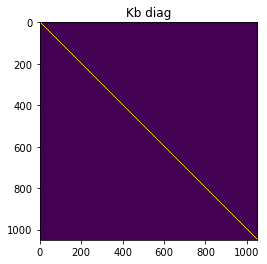

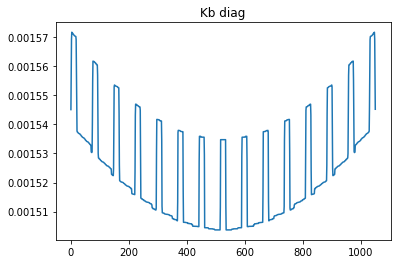

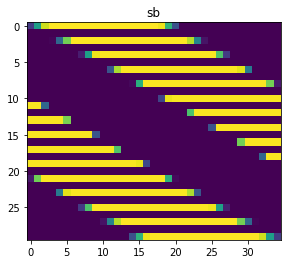

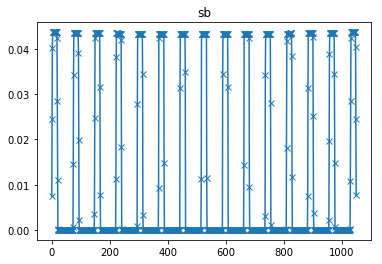

In [4]:
# plot Kb and sb
plt.imshow(Kb.A)
plt.title('Kb diag')
plt.show()
plt.close()

plt.plot(Kb.diagonal())
plt.title('Kb diag')
plt.show()
plt.close()

plt.imshow(sb.reshape(30,35,order='C'))
# plt.plot(sb)
plt.title('sb')
plt.show()
plt.close()

plt.plot(sb,marker='x')
plt.title('sb')
plt.show()
plt.close()

7.7778615292


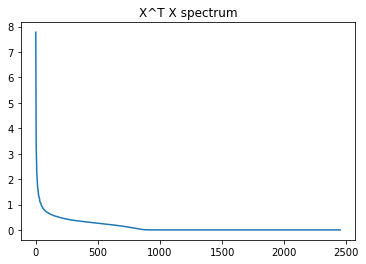

In [5]:
U,S,V = la.svd(X.T.dot(X).A)
print(S[0])
plt.plot(S)
plt.title('X^T X spectrum')
plt.show()
plt.close()

In [6]:
###### quick testing ######
# Rs.append(spsla.spsolve(X.T.dot(X) + lams[-1]*sps.eye(n), X.T, use_umfpack=True))

# Direct
---

In [7]:
# construct R
Rs = []
for lam in lams:
    Rs.append(spsla.spsolve(X.T.dot(X) + lam*sps.eye(n), X.T, use_umfpack=True))

In [8]:
# test specific lambda
idx = -1
R = Rs[idx]
lam = lams[idx]
print('testing lambda: %s' % lam)

testing lambda: 1e-28


LHS size: (30,30)
RHS size: (30,1)


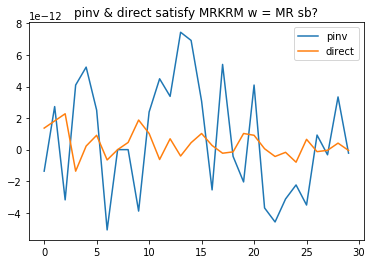

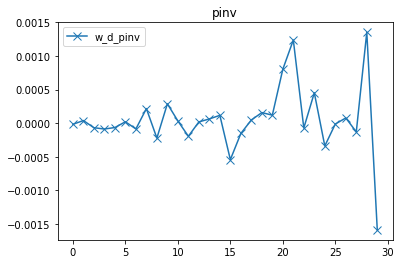

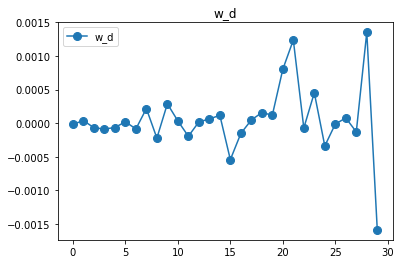

size MRKRM: (30,30)


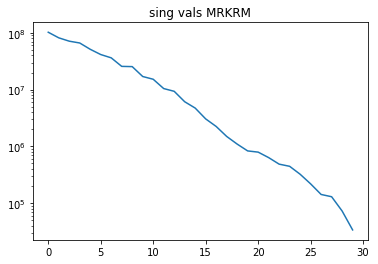

In [9]:
w_d,_,_ = util.direct_solve(Kb=Kb, R=R, M=M, B=None, sb=sb, sparse=True)
LHS = M.dot(R).dot(Kb).dot(R.T).dot(M.T)
RHS = M.dot(R).dot(sb)
w_d_pinv = la.pinv(LHS.toarray(), rcond=10e-12).dot(RHS)  # 10e-2 for lam3

print('LHS size: (%s,%s)' % LHS.shape)
print('RHS size: (%s,%s)' % RHS.shape)

ee_pinv = LHS.dot(w_d_pinv) - RHS  # MRKRM w = MRs equation error
ee_dir = LHS.dot(w_d) - RHS
plt.plot(ee_pinv, label='pinv')
plt.plot(ee_dir, label='direct')
plt.title('pinv & direct satisfy MRKRM w = MR sb?')
plt.legend()
plt.show()
plt.close()

plt.plot(w_d_pinv,label='w_d_pinv',marker='x',markersize=8)
plt.legend()
plt.title('pinv')
plt.show()
plt.close()

plt.plot(w_d,label='w_d',marker='o',markersize=8)
plt.legend()
plt.title('w_d')
plt.show()
plt.close()

U,S,V = la.svd(LHS.A)
print('size MRKRM: (%s,%s)' % LHS.A.shape)
plt.yscale('log')
plt.plot(S)
plt.title('sing vals MRKRM')
plt.show()
plt.close()

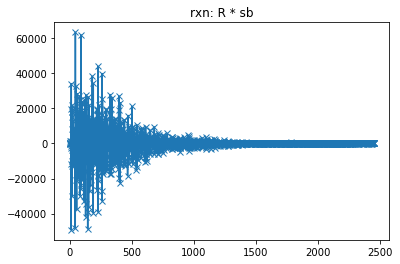

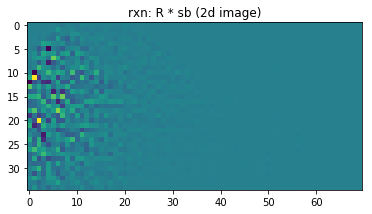

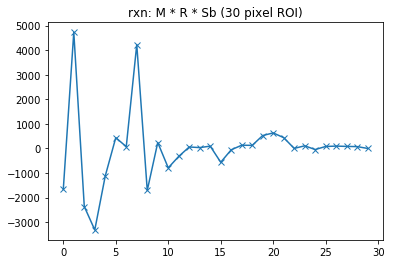

In [10]:
# plot reconstructions
rxn = R.dot(sb)
plt.plot(rxn,marker='x')
plt.title('rxn: R * sb')
plt.show()
plt.close()

plt.imshow(rxn.reshape(35,70,order="F"))
plt.title('rxn: R * sb (2d image)')
plt.show()
plt.close()

plt.plot(M.dot(rxn),marker='x')
plt.title('rxn: M * R * Sb (30 pixel ROI)')
plt.show()
plt.close()

# ESI System
---

In [11]:
# generate system
ESI_A, ESI_b = util.gen_ESI_system(X=X, Kb=Kb, B=None, M=M, lam=lam, sb=sb)

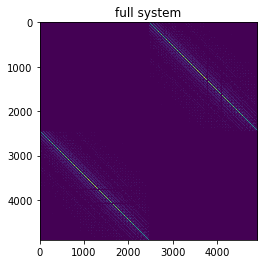

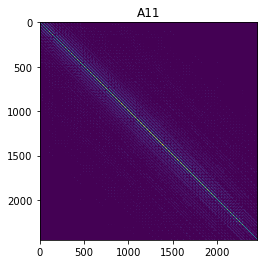

25.9577783902
16753.2016362


In [12]:
# check system
plt.imshow(ESI_A.A)
plt.title('full system')
plt.show()

plt.imshow(ESI_A.A[0:2450,0:2450])
plt.title('A11')
plt.show()

print(sum(sum(ESI_A.A[0:2450,0:2450])))
print(sum(sum(ESI_A.A[0:2450,2450:4900])))

# ## block LHS
# B = sps.eye(n)
# Z = (X.T.dot(X) + lam*B.T.dot(B))
# A11 = X.T.dot(Kb).dot(X)
# A12 = Z.dot(sps.eye(n) - M.T.dot(M))
# A21 = A12.T
# A22 = None

# fig = plt.figure()

# plt.subplot(221)
# plt.imshow(A11.A)
# plt.title('A11')

# plt.subplot(222)
# plt.imshow(A12.A)
# plt.title('A12')

# plt.subplot(223)
# plt.imshow(A21.A)
# plt.title('A21')
# plt.show()
# plt.close()

# A11 = sps.csr_matrix(np.diag([10,10,10,10]))
# A12 = sps.csr_matrix(np.random.randn(4,4))
# A21 = A12.T
# A = sps.bmat([[A11,A12], [A21,None]])
# plt.imshow(A.A[0:4,0:4])
# plt.show()
# plt.close()

# plt.plot(ESI_b)
# plt.show()
# plt.close()

In [13]:
# set solution parameters
tol = 1e-15
niter = 1000

# CVX: speed tests
---

> ## solve


time: 4.30513906479, solver: CVXOPT


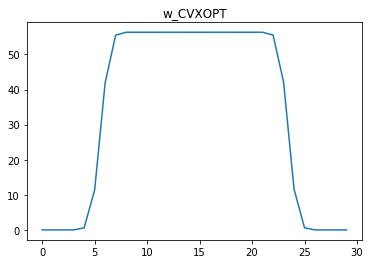

time: 0.131950855255, solver: MOSEK


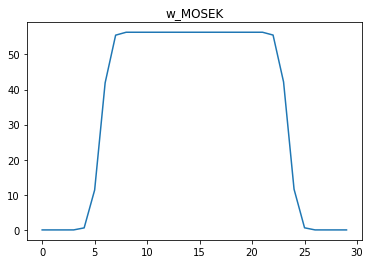

time: 0.354103088379, solver: ECOS_BB


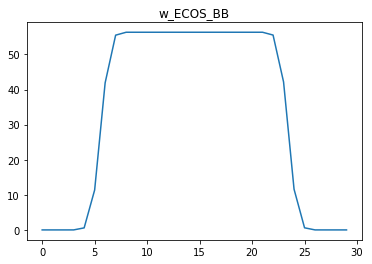

time: 0.0872030258179, solver: SCS


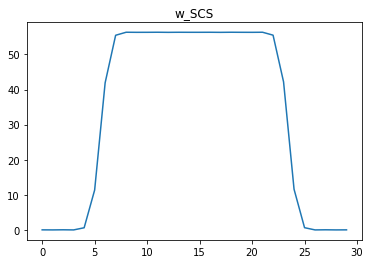

time: 0.362771987915, solver: ECOS


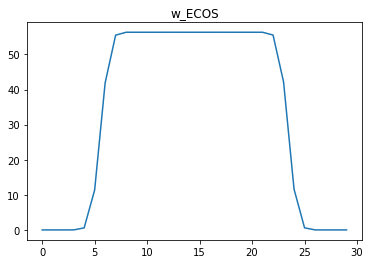

time: 1.67062187195, solver: GUROBI


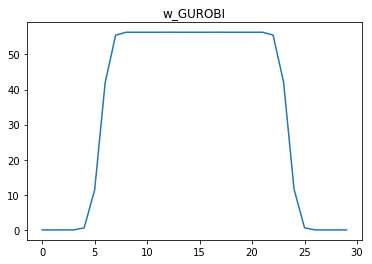

In [14]:
solvers = [s for s in cvx.installed_solvers()]
solvers.remove('GLPK_MI')
solvers.remove('GLPK')
solvers.remove('LS')

for s in solvers:
    t0 = time.time()

    # variables
    u = cvx.Variable(n)

    # problem
    K_12 = sps.spdiags([np.sqrt(x) for x in Kb_diag], diags=0, m=m, n=m)      # cholesky
    K_12_1 = sps.spdiags([1./x for x in K_12.diagonal()], diags=0, m=m, n=m)  # inverse cholesky
    obj = cvx.Minimize( cvx.norm(K_12*X*u - K_12_1*sb))
    constr = [(sps.eye(n) - M.T.dot(M))*u == float(0)]
    prob = cvx.Problem(obj, constr)

    # solve for u
    result = prob.solve(solver=s, verbose=False)

    # plot u
    t1 = time.time()
    print('time: %s, solver: %s' % ((t1-t0), s))
    u_cvx = u.value
#     plt.plot(u.value)
#     plt.title('u_cvx')
#     plt.show()
#     plt.close()
    
    w_cvx = util.calc_hot(X=X, B=None, lam=lam, M=M, u=u_cvx, ESI=True)
    plt.plot(w_cvx)
    plt.title('w_'+str(s))
    plt.show()
    plt.close()

# CVX: MOSEK
---

> ## solve


(1050, 1050)
(1050, 1050)
(1050, 2450)
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3501            
  Cones                  : 1               
  Scalar variables       : 3502            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 0
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   :                 
  Objective sense        : min             
  Type    

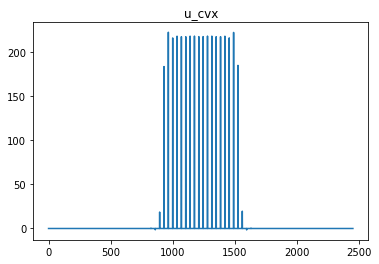

In [15]:
t0 = time.time()

# variables
u = cvx.Variable(n)

# problem
K_12 = sps.spdiags([np.sqrt(x) for x in Kb_diag], diags=0, m=m, n=m)      # cholesky
K_12_1 = sps.spdiags([1./x for x in K_12.diagonal()], diags=0, m=m, n=m)  # inverse cholesky
print(K_12.shape)
print(K_12_1.shape)
print(X.shape)
obj = cvx.Minimize( cvx.norm(K_12*X*u - K_12_1*sb))
constr = [(sps.eye(n) - M.T.dot(M))*u == float(0)]
prob = cvx.Problem(obj, constr)

# solve for u
mosek_params = {'MSK_IPAR_OPTIMIZER':2}  # 2: conic (http://docs.mosek.com/8.0/capi/constants.html#optimizertype)
mosek_params['MSK_DPAR_INTPNT_CO_TOL_REL_GAP'] = 1e-13    # doesn't seem to work with `tol` tolerance; breaks at 1e-14
mosek_params['MSK_IPAR_INTPNT_MAX_ITERATIONS'] = niter    # doesn't seem to work...
result = prob.solve(solver='MOSEK', mosek_params=mosek_params, verbose=True)

# plot u
t1 = time.time()
print('time: %s' % (t1-t0))
u_cvx = u.value
plt.plot(u.value)
plt.title('u_cvx')
plt.show()
plt.close()

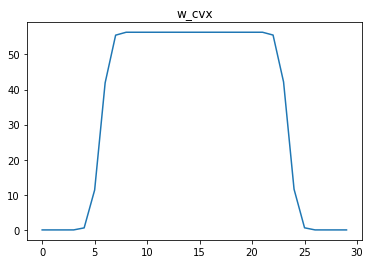

In [16]:
w_cvx = util.calc_hot(X=X, B=None, lam=lam, M=M, u=u_cvx, ESI=True)
plt.plot(w_cvx)
plt.title('w_cvx')
plt.show()
plt.close()

> ## check


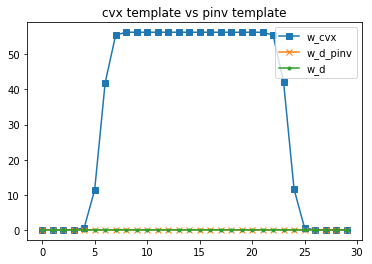

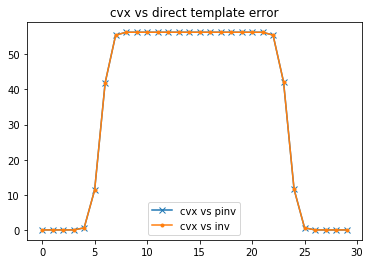

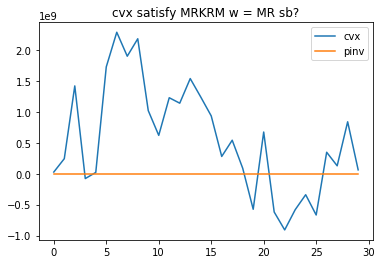

[[  2.42798130e+10]]


In [17]:
plt.plot(w_cvx, label='w_cvx', marker='s')
plt.plot(w_d_pinv, label='w_d_pinv', marker='x')
plt.plot(w_d, label='w_d', marker='o', markersize=3)
plt.title('cvx template vs pinv template')
plt.legend()
plt.show()
plt.close()

e_cvx = w_cvx - w_d
e_cvx_pinv = w_cvx - w_d_pinv
plt.plot(e_cvx_pinv, label='cvx vs pinv', marker='x')
plt.plot(e_cvx, label='cvx vs inv', marker='o', markersize=3)
plt.title('cvx vs direct template error')
plt.legend()
plt.show()
plt.close()

ee_cvx = LHS.dot(w_cvx) - RHS  # MRKRM w = MRs equation error
plt.plot(ee_cvx, label='cvx')
plt.plot(ee_pinv, label='pinv')
plt.legend()
plt.title('cvx satisfy MRKRM w = MR sb?')
plt.show()
plt.close()
print(sum(abs(ee_cvx)))

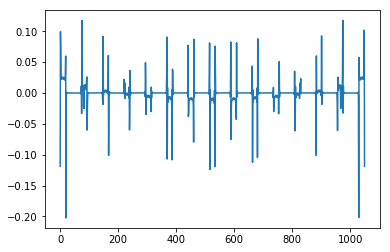

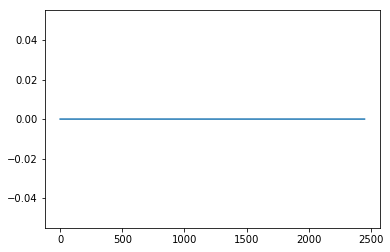

In [18]:
# check minimzation
z = K_12.dot(X).dot(u_cvx[0:n]) - K_12_1.dot(sb)
plt.plot(z)
plt.show()

# check constraint
c = (sps.eye(n) - M.T.dot(M)).dot(u_cvx[0:n])
plt.plot(c)
plt.show()

# MINRES
---

> ## solve


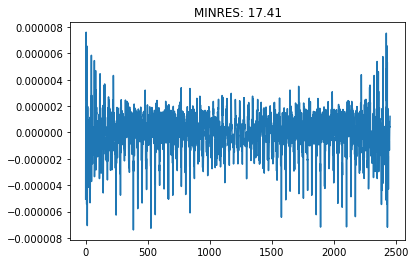

In [19]:
# solve for u
u_m, _, us_m, mr_m, t_m, tt_m = spsla.minres_track(A=ESI_A, b=ESI_b, tol=tol, maxiter=niter)
u_m = u_m.reshape(len(u_m),1)
plt.title('MINRES: '+ str(round(tt_m,3)))
plt.plot(u_m[0:n])# check minimzation
plt.show()
plt.close()

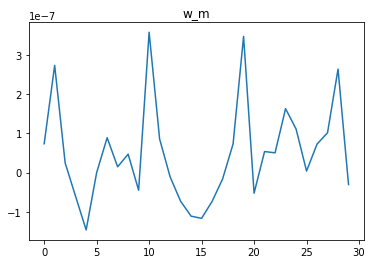

In [20]:
# compute w
w_m = util.calc_hot(X=X, B=None, lam=lam, M=M, u=u_m, ESI=True)
plt.plot(w_m)
plt.title('w_m')
plt.show()
plt.close()

> ## check


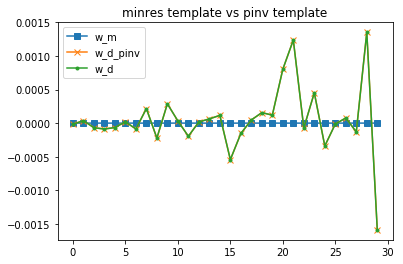

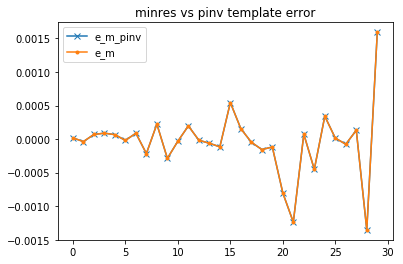

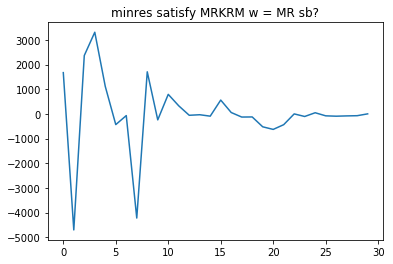

In [21]:
plt.plot(w_m, label='w_m', marker='s')
plt.plot(w_d_pinv, label='w_d_pinv', marker='x')
plt.plot(w_d, label='w_d', marker='o', markersize=3)
plt.title('minres template vs pinv template')
plt.legend()
plt.show()
plt.close()

e_m = w_m - w_d
e_m_pinv = w_m - w_d_pinv
plt.plot(e_m_pinv, label='e_m_pinv', marker='x')
plt.plot(e_m, label='e_m', marker='o', markersize=3)
plt.title('minres vs pinv template error')
plt.legend()
plt.show()
plt.close()

ee_m = LHS.dot(w_m) - RHS
plt.plot(ee_m)
plt.title('minres satisfy MRKRM w = MR sb?')
plt.show()
plt.close()

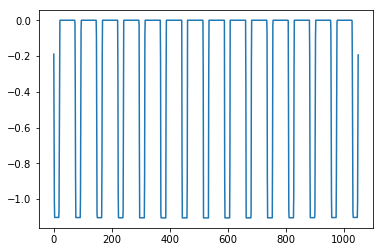

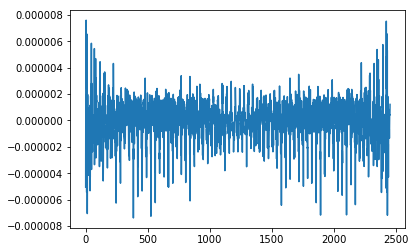

In [22]:
# check minimzation
z = K_12.dot(X).dot(u_m[0:n]) - K_12_1.dot(sb)
plt.plot(z)
plt.show()

# check constraint
c = (sps.eye(n) - M.T.dot(M)).dot(u_m[0:n])
plt.plot(c)
plt.show()

# POCS
---

> ## solve


----- POCS -----------------------
(0.0, 'pocs constr 0')
(83.637547780980981, 'pocs resid 0')
----- POCS -----------------------
    pocs runtime: 4.869


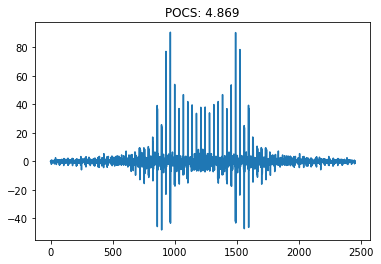

In [23]:
# solve for u
u_p, mr_p, cr_p, t_p, us_p, hr_p, tt_p = projection.pocs(
            Kb, X, sb, lam, M, max_iter=2, tol=tol, full_output=1, R=R
)
u_p = u_p.reshape(len(u_p),1)
plt.title('POCS: '+ str(round(tt_p,3)))
plt.plot(u_p[0:n])# check minimzation
plt.show()
plt.close()

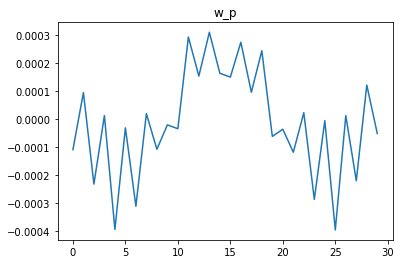

In [24]:
# compute w
w_p = util.calc_hot(X=X, B=None, lam=lam, M=M, u=u_p, ESI=True)
plt.plot(w_p)
plt.title('w_p')
plt.show()
plt.close()

> ## check


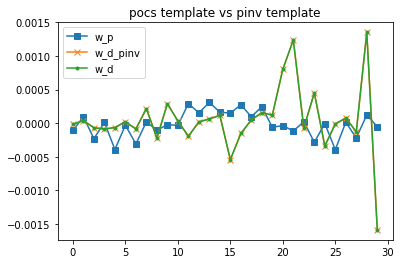

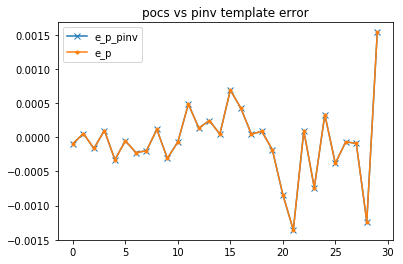

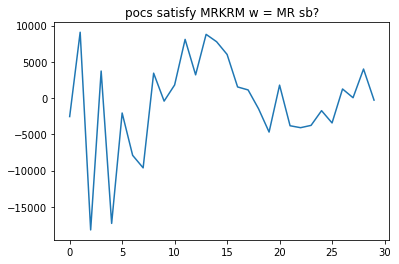

In [25]:
plt.plot(w_p, label='w_p', marker='s')
plt.plot(w_d_pinv, label='w_d_pinv', marker='x')
plt.plot(w_d, label='w_d', marker='o', markersize=3)
plt.title('pocs template vs pinv template')
plt.legend()
plt.show()
plt.close()

e_p = w_p - w_d
e_p_pinv = w_p - w_d_pinv
plt.plot(e_p_pinv, label='e_p_pinv', marker='x')
plt.plot(e_p, label='e_p', marker='o', markersize=3)
plt.title('pocs vs pinv template error')
plt.legend()
plt.show()
plt.close()

ee_p = LHS.dot(w_p) - RHS
plt.plot(ee_p)
plt.title('pocs satisfy MRKRM w = MR sb?')
plt.show()
plt.close()

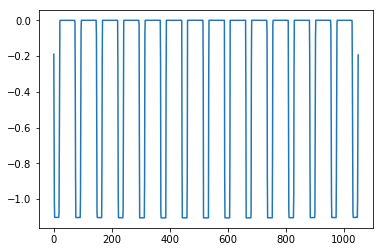

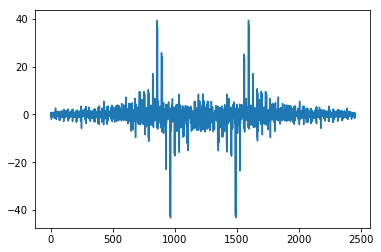

In [26]:
# check minimzation
z = K_12.dot(X).dot(u_p[0:n]) - K_12_1.dot(sb)
plt.plot(z)
plt.show()

# check constraint
c = (sps.eye(n) - M.T.dot(M)).dot(u_p[0:n])
plt.plot(c)
plt.show()